In [65]:
import pandas as pd
import numpy as np
import urllib.request
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

import warnings
warnings.filterwarnings("ignore")

In [66]:
# download dataset

data_url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"

filename = "cars_data.csv"

if not os.path.exists(filename):
    urllib.request.urlretrieve(data_url, filename)

df_in = pd.read_csv(filename)

In [67]:
def df_clean(df):
    """
    Clean the dataframe - convert column names to lower case and replace spaces 
    with underscores.
    Remove NaNs.
    Modifies df in place.
    """
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    
    string_columns = df.dtypes[df.dtypes == "object"].index

    for col in string_columns:
        df[col] = df[col].str.lower().str.replace(" ", "_")

    df = df.fillna(0)

    return df

# clean the dataframe
df_in  = df_clean(df_in)

In [68]:
MAKES = [
            "chevrolet",
            "ford",
            "volkswagen",
            "toyota",
            "dodge",
            "nissan",
            "gmc",
            "honda",
            "mazda",
            "cadillac"
        ]

FUEL_TYPES = list(df_in.engine_fuel_type.unique())

TRANSMISSIONS = list(df_in.transmission_type.unique())

WD_TYPES = list(df_in.driven_wheels.unique())

MARKET_CATEGORIES = list(df_in.market_category.unique())

VEHICLE_SIZES = list(df_in.vehicle_size.unique())

VEHICLE_STYLES = list(df_in.vehicle_style.unique())

def process_features(df):
    """
    Process features - convert categoricals into dummies.
    Returns a new dataframe.
    """
    _df = df.copy()

    _features = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]

    # add age column
    _df["age"] = 2017 - _df.year
    _features.append("age")

    # convert num doors into dummies
    for v in [2, 3, 4]:
        _df[f"num_doors_{v}"] = (df.number_of_doors == v).astype(int)
        _features.append(f"num_doors_{v}")

    # use 10 most popular makes as dummies
    for make in MAKES:
        _df[f"make_{make}"] = (_df.make == make).astype(int)
        _features.append(f"make_{make}")

    for fuel in FUEL_TYPES:
        _df[f"fuel_{fuel}"] = (_df.engine_fuel_type == fuel).astype(int)
        _features.append(f"fuel_{fuel}")

    for transmission in TRANSMISSIONS:
        _df[f"transmission_{transmission}"] = (_df.transmission_type == transmission).astype(int)
        _features.append(f"transmission_{transmission}")

    for wd in WD_TYPES:
        _df[f"wd_{wd}"] = (_df.driven_wheels == wd).astype(int)
        _features.append(f"wd_{wd}")

    for cat in MARKET_CATEGORIES:
        _df[f"cat_{cat}"] = (_df.market_category == cat).astype(int)
        _features.append(f"cat_{cat}")

    for s in VEHICLE_SIZES:
        _df[f"size_{s}"] = (_df.vehicle_size == s).astype(int)
        _features.append(f"size_{s}")

    for s in VEHICLE_STYLES:
        _df[f"style_{s}"] = (_df.vehicle_style == s).astype(int)
        _features.append(f"style_{s}")

    _features.append("msrp")

    _features = list(filter(lambda x: not x.endswith("_0"), _features))

    return _df[_features]

In [69]:
# feature engineering

df = process_features(df_in)

In [70]:
# functional testing

# verify if column names are converted to lower case and spaces are replaced with underscores
for col in df.columns:
    assert col == col.lower().replace(" ", "_")

# verify if string columns are converted to lower case and spaces are replaced with underscores
string_columns = df.dtypes[df.dtypes == "object"].index
for col in string_columns:
    assert df[col].str.contains(" ").sum() == 0

REQUIRED_FEATURES = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]
REQUIRED_FEATURES += ["age"]
REQUIRED_FEATURES += [f"num_doors_{v}" for v in [2, 3, 4]]
REQUIRED_FEATURES += [f"make_{make}" for make in MAKES]
REQUIRED_FEATURES += [f"fuel_{fuel}" for fuel in FUEL_TYPES]
REQUIRED_FEATURES += [f"transmission_{transmission}" for transmission in TRANSMISSIONS]
REQUIRED_FEATURES += [f"wd_{wd}" for wd in WD_TYPES]
REQUIRED_FEATURES += [f"cat_{cat}" for cat in MARKET_CATEGORIES]
REQUIRED_FEATURES += [f"size_{s}" for s in VEHICLE_SIZES]
REQUIRED_FEATURES += [f"style_{s}" for s in VEHICLE_STYLES]
REQUIRED_FEATURES += ["msrp"]

REQUIRED_FEATURES = list(filter(lambda x: not x.endswith("_0"), REQUIRED_FEATURES))

assert set(df.columns) == set(REQUIRED_FEATURES)

In [71]:
# store feature index for later

print(f"df shape: {df.shape}")

features = list(filter(lambda x: x != "msrp", df.columns))
features = pd.Index(features)
n_features = len(features)

print(features)

df shape: (11914, 129)
Index(['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg',
       'popularity', 'age', 'num_doors_2', 'num_doors_3', 'num_doors_4',
       'make_chevrolet',
       ...
       'style_4dr_suv', 'style_passenger_minivan', 'style_cargo_minivan',
       'style_crew_cab_pickup', 'style_regular_cab_pickup',
       'style_extended_cab_pickup', 'style_2dr_suv', 'style_cargo_van',
       'style_convertible_suv', 'style_passenger_van'],
      dtype='object', length=128)


In [72]:
# dataset split helper

def split_dataset(df, val_size=0., test_size=0.2):
    """Split dataframe (including labels) into train, validation and test sets."""
    np.random.seed(0)

    n = len(df)

    n_val, n_test = 0, 0

    if val_size > 0:
        n_val = int(n * val_size)

    if test_size > 0:
        n_test = int(n * test_size)

    n_train = n - n_val - n_test

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]

    df_val, df_test = None, None

    if n_val > 0:
        df_val = df.iloc[idx[n_train:n_train+n_val]]

    if n_test > 0:
        df_test = df.iloc[idx[n_train+n_val:]]

    return df_train, df_val, df_test
    

def prepare_X_y(df):
    """Prepare X, y from dataframe. Return as numpy arrays. Convert y to logs."""
    X = df.drop("msrp", axis=1).values
    y = np.log1p(df.msrp.values)

    return X, y

In [73]:
df_train, df_val, df_test = split_dataset(df, val_size=0.2, test_size=0.2)

print(f"df_train shape: {df_train.shape}")
print(f"df_val shape: {df_val.shape}")
print(f"df_test shape: {df_test.shape}")

X_train, y_train = prepare_X_y(df_train)
X_val, y_val = prepare_X_y(df_val)
X_test, y_test = prepare_X_y(df_test)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# automatic assertions

assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]
assert X_test.shape[0] == y_test.shape[0]


df_train shape: (7150, 129)
df_val shape: (2382, 129)
df_test shape: (2382, 129)
X_train shape: (7150, 128)
y_train shape: (7150,)
X_val shape: (2382, 128)
y_val shape: (2382,)
X_test shape: (2382, 128)
y_test shape: (2382,)


In [74]:
def rmse(y, y_pred):
    error = y - y_pred
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [75]:
logs = np.logspace(0, 1, num=10, base=10) - 1
regularization_params = logs / logs.max()
regularization_params = np.hstack([logs / logs.max() * 0.1, logs / logs.max()])

scores = []

for r in regularization_params:
    model = linear_model.Ridge(alpha=r)
    model.fit(X_train, y_train)

    # calculate RMSE on validation set
    y_hat = model.predict(X_val)
    score = rmse(y_val, y_hat)

    scores.append({"alpha": r, "rmse": score})

for score in scores:
    print(f"alpha: {score['alpha']:.4f}, rmse: {score['rmse']:.8f}")

r = min(scores, key=lambda x: x["rmse"])["alpha"]

print(f"Best alpha: {r:.4f} @ RMSE: {min(scores, key=lambda x: x['rmse'])['rmse']:.8f}")

alpha: 0.0000, rmse: 657216797.36965573
alpha: 0.0032, rmse: 0.41809841
alpha: 0.0074, rmse: 0.41808765
alpha: 0.0128, rmse: 0.41807421
alpha: 0.0198, rmse: 0.41805760
alpha: 0.0288, rmse: 0.41803733
alpha: 0.0405, rmse: 0.41801305
alpha: 0.0555, rmse: 0.41798463
alpha: 0.0749, rmse: 0.41795244
alpha: 0.1000, rmse: 0.41791766
alpha: 0.0000, rmse: 657216797.36965573
alpha: 0.0324, rmse: 0.41802966
alpha: 0.0742, rmse: 0.41795349
alpha: 0.1283, rmse: 0.41788659
alpha: 0.1981, rmse: 0.41784004
alpha: 0.2882, rmse: 0.41782748
alpha: 0.4046, rmse: 0.41786374
alpha: 0.5550, rmse: 0.41796306
alpha: 0.7492, rmse: 0.41813714
alpha: 1.0000, rmse: 0.41839421
Best alpha: 0.2882 @ RMSE: 0.41782748


In [76]:
# model candidate

model = linear_model.Ridge(alpha=r)
model.fit(X_train, y_train)

rmse(y_val, model.predict(X_val))

np.float64(0.41782747778738943)

In [77]:
# error analysis on val set

predicted_logs = model.predict(X_val)
actual_logs = y_val

predicted_prices = np.expm1(predicted_logs)
actual_prices = np.expm1(actual_logs)

print(f"predicted prices: {predicted_prices[:5].round(0)}")
print(f"actual prices: {actual_prices[:5]}")

predicted prices: [21415. 28542. 30046. 48149. 42744.]
actual prices: [29895. 23330. 23150. 48065. 52750.]


In [78]:
# model score on test set

rmse(y_test, model.predict(X_test))

np.float64(0.41880111013987315)

Text(0, 0.5, 'Frequency')

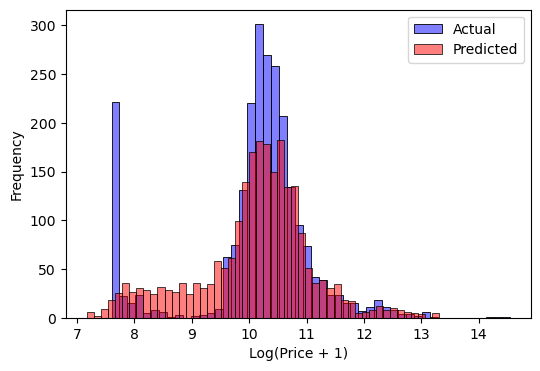

In [64]:
# test set error analysist

# model is biased in lower price range
# probably there's some unaccounted feature that affects low end prices

plt.figure(figsize=(6, 4))

sns.histplot(y_test, color="blue", alpha=0.5, bins=50)
sns.histplot(model.predict(X_test), color="red", alpha=0.5, bins=50)

plt.legend(["Actual", "Predicted"])
plt.xlabel("Log(Price + 1)")
plt.ylabel("Frequency")

In [90]:
# single forecast

sample_json = df_test.iloc[4].to_dict() # this comes via API

sample = pd.DataFrame([sample_json])

X, y = prepare_X_y(sample)

predicted_log = model.predict(X)[0]
predicted_px = np.expm1(predicted_log)

actual_px = np.expm1(y)[0]

print(f"Predicted price: {predicted_px:.2f}")
print(f"Actual price: {actual_px:.2f}")

Predicted price: 38070.88
Actual price: 26600.00
